This notebook aims to test our framework it the purely gaussian case.

## Validate the gaussian prior

In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
from jax.experimental import optix
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

#from jax_lensing.models.convdae import UResNet, SmallUResNet
from jax_lensing.inversion import ks93inv, ks93
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

from astropy.io import fits

import types
from typing import Mapping, Optional, Sequence, Union

In [179]:
dataset = "kappatng"
#weight_dir = "../weights/gp-sn1v2"
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2

In [180]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [181]:
# load convergence maps
train_set = load_dataset(dataset,
                         batch_size,
                         map_size,
                         noise_dist_std,
                         train_split)

dict_keys(['x', 'y', 'u', 's'])


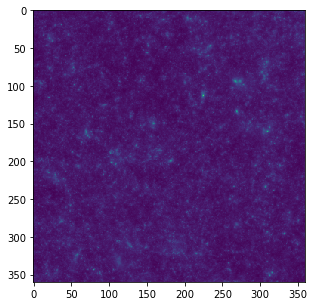

In [182]:
batch = next(train_set)
print(batch.keys())
imshow(batch['x'][0,...,0])

Compute PS from a map

In [9]:
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
ell, power_spectrum_1d = measure_power_spectrum(batch['x'][0,...,0], pixel_size)
ps_data = jnp.stack([ell, power_spectrum_1d], axis=0)

Import theoretical PS

In [183]:
ps_data = onp.load(gaussian_path).astype('float32')

In [191]:
def make_power_map(power_spectrum, size, kps=None, zero_freq_val=1e-2):
  #Ok we need to make a map of the power spectrum in Fourier space
  k1 = np.fft.fftfreq(size)
  k2 = np.fft.fftfreq(size)
  kcoords = np.meshgrid(k1,k2)
  # Now we can compute the k vector
  k = np.sqrt(kcoords[0]**2 + kcoords[1]**2)
  if kps is None:
    kps = np.linspace(0,0.5,len(power_spectrum))
  # And we can interpolate the PS at these positions
  ps_map = np.interp(k.flatten(), kps, power_spectrum).reshape([size,size])
  ps_map = ps_map
  ps_map[0,0] = zero_freq_val
  return ps_map # Carefull, this is not fftshifted

In [192]:
# If the Gaussian prior is used, load the theoretical power spectrum
if gaussian_prior:
    #ps_data = onp.load(gaussian_path).astype('float32')
    ell = jnp.array(ps_data[0,:])

    # normalisation by pixel size
    ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2)
    
    # convert to pixel units of our simple power spectrum calculator
    #kell = ell / (360/3.5/0.5)# / float(map_size)
    kell = ell /2/jnp.pi * 360 * pixel_size
    
    # Interpolate the Power Spectrum in Fourier Space
    power_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))
    ps_map = power_map

In [186]:
ind = 30
map_data = batch['x'][ind,...,0]

data_ft = jnp.fft.fft2(map_data) / float(map_size)
jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / ps_map)

DeviceArray(17.135826, dtype=float32)

DeviceArray(6.0104294, dtype=float32)

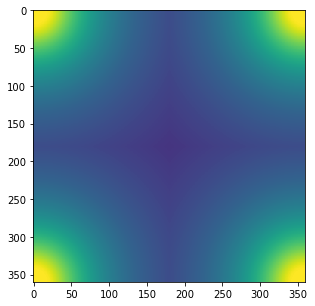

In [203]:
#imshow(jnp.real(data_ft*jnp.conj(data_ft)) / ps_map); colorbar()
imshow(ps_map, vmax=6.01)
jnp.max(ps_map)

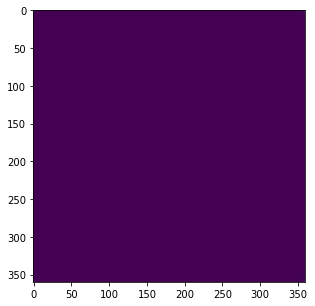

In [204]:
imshow(jnp.real(data_ft*jnp.conj(data_ft)), vmax=6.01)
#jnp.(jnp.real(data_ft*jnp.conj(data_ft)))

## Compute MAP in the gaussian case

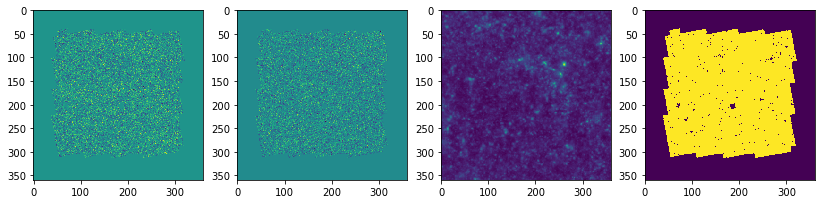

In [147]:
# import shear map, ground truth convergence and mask
true_shear = fits.getdata('../data/ktng/ktng_cosmos_e360.fits').astype('float32')
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360.fits').astype('float32')

mask_shear = jnp.stack([mask, mask], axis=-1)#.flatten()
masked_true_shear = true_shear * mask_shear

figure(figsize(14,5))
subplot(141)
imshow(true_shear[..., 0])
subplot(142)
imshow(true_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask)

In [137]:
g1, g2 = ks93inv(convergence, jnp.zeros_like(convergence))
true_shear = jnp.stack([g1, g2], axis=-1)
masked_true_shear = true_shear * mask_shear

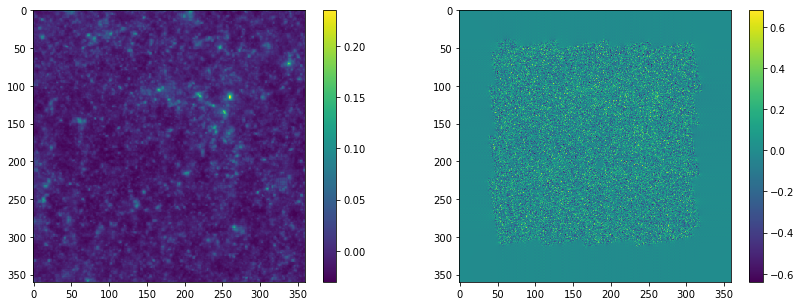

In [205]:
# Initialize with KS93
subplot(121)
imshow(convergence)
colorbar()
subplot(122)
kappa_init, _ = ks93(masked_true_shear[...,0], masked_true_shear[...,1])
imshow(kappa_init)
colorbar()
kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [172]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size)
kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [206]:
# compute likelihood
shear_noise = 0.148

def likelihood_fn(x):
    ke = x.reshape(map_size, map_size)
    kb = jnp.zeros_like(ke)
    gamma1, gamma2 = ks93inv(ke, kb)
    compute_shear = jnp.stack([gamma1, gamma2], axis=-1) * mask_shear
    return jnp.sum( ((compute_shear - masked_true_shear)**2) /(shear_noise**2)/2 )

score_likelihood = jax.vmap(jax.grad(likelihood_fn))

In [218]:
# compute MAP update
eps = 1e-3

@jax.jit
def update(x_old):
    # prior score
    gaussian_prior = gaussian_prior_score(x_old, jnp.zeros((1,1,1)), ps_map)
    
    # likelihood score
    score_lh = score_likelihood(x_old)
    
    score_post = + gaussian_prior# - score_lh 
    
    x_new = x_old + eps * score_post
    
    return x_new

In [219]:
x_old = kappa_init.copy()
loss = []
samples = []

n_steps = 5000

for i in tqdm(range(n_steps)):
    x_new = update(x_old)
    l = jnp.mean(jnp.linalg.norm(convergence[...,0] - x_new[0,...]))
    loss.append(l)
    samples.append(x_new)
    x_old = x_new

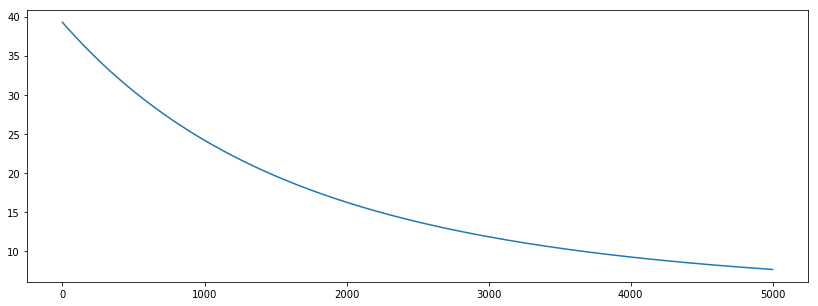

In [220]:
plot(loss)

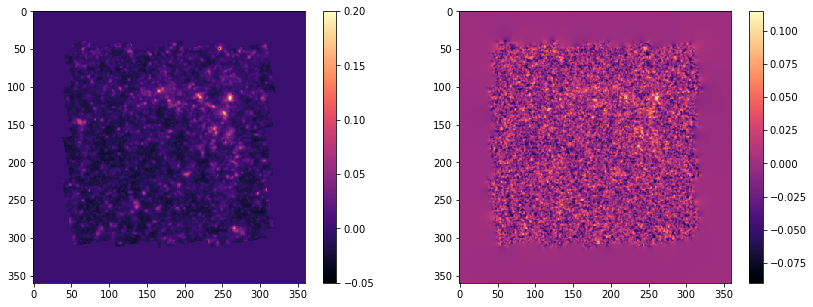

In [221]:
vmin = -0.05
vmax = 0.2

subplot(121)
imshow(convergence*mask, cmap='magma', vmin=vmin, vmax=vmax)
colorbar()
subplot(122)
imshow(x_new[0,...], cmap='magma')#, vmin=vmin, vmax=vmax)
colorbar()

In [217]:
#score_likelihood(kappa_init)
#gaussian_prior_score(kappa_init, jnp.zeros((1,1,1)), power_map).shape

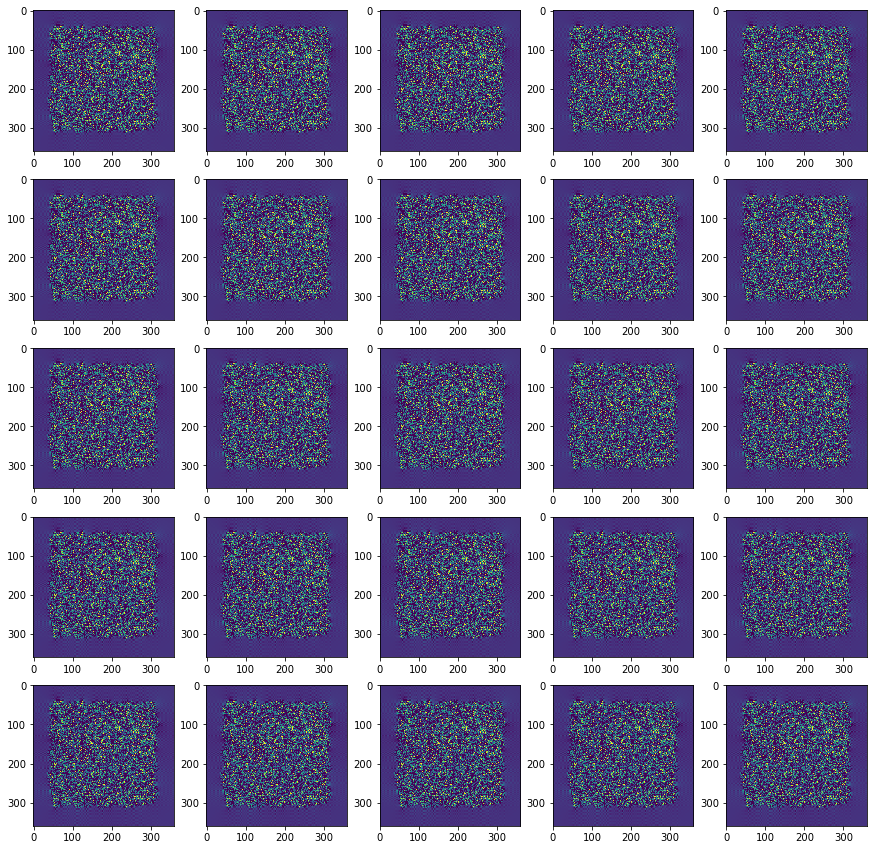

In [168]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5,5,i*5+j+1)
        imshow(samples[(i*5+j)*100].reshape(360, 360), vmin=-0.05,vmax=0.3)